# Import DataFrame from Azure Storage Blob

In [1]:
import pandas as pd  # Import Pandas
import numpy as np  # Import Numpy
import os  # Import OS
import warnings  #ignore warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Import clients from Azure
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

# Set connection string
connect_str = "DefaultEndpointsProtocol=https;AccountName=thegroupproject;AccountKey=ZrsqB0h1P58bItB4WmuXcKAzGbXBFI/mGa6M6jYYvyuPgDQ5kqjPI8DJbvDhSsuwqVQqwoqzU8mA+AStHubvaQ==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Set parameters
container_name = "healthcare-group-project"
blob_name1 = "healthcare_patient_satisfaction_df.csv"
blob_name2 = "new_healthcare_patient_satisfaction_df.csv"

try:
    # Download first blob
    blob_client1 = blob_service_client.get_blob_client(container=container_name, blob=blob_name1)
    with open(blob_name1, "wb") as file:
        blob_data = blob_client1.download_blob()
        file.write(blob_data.readall())
    print(f"Successfully downloaded {blob_name1} from Azure Blob Storage.")

    # Download second blob
    blob_client2 = blob_service_client.get_blob_client(container=container_name, blob=blob_name2)
    with open(blob_name2, "wb") as file:
        blob_data = blob_client2.download_blob()
        file.write(blob_data.readall())
    print(f"Successfully downloaded {blob_name2} from Azure Blob Storage.")

    # Read the files into Pandas DataFrames
    df = pd.read_csv(blob_name1)
    new_df = pd.read_csv(blob_name2)

    print("CSV data from the first file:")
    print(df.head(3)) 

    print("\nCSV data from the second file:")
    print(new_df.head(3))

except Exception as e:
    print(f"Error occurred: {str(e)}")

Successfully downloaded healthcare_patient_satisfaction_df.csv from Azure Blob Storage.
Successfully downloaded new_healthcare_patient_satisfaction_df.csv from Azure Blob Storage.
CSV data from the first file:
  Facility ID                     Facility Name                 Address  \
0      010001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
1      010001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
2      010001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   

     City State Full State Name  ZIP Code County Name    Phone Number  \
0  DOTHAN    AL         Alabama     36301     HOUSTON  (334) 793-8701   
1  DOTHAN    AL         Alabama     36301     HOUSTON  (334) 793-8701   
2  DOTHAN    AL         Alabama     36301     HOUSTON  (334) 793-8701   

  HCAHPS Measure ID                                    HCAHPS Question  \
0      H_COMP_1_A_P  Patients who reported that their nurses Always...   
1     H_COMP_1_SN_P  Patients who reported that 

## Modelling

### Copy the dataframe

In [2]:
# Copy dataframe before encoding
original_df = df.copy()

#### Drop Null Values if exists

In [3]:
# Remove all rows with NaN values
df.dropna(inplace=True)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520966 entries, 0 to 1060172
Data columns (total 36 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Facility ID                                            520966 non-null  object 
 1   Facility Name                                          520966 non-null  object 
 2   Address                                                520966 non-null  object 
 3   City                                                   520966 non-null  object 
 4   State                                                  520966 non-null  object 
 5   Full State Name                                        520966 non-null  object 
 6   ZIP Code                                               520966 non-null  int64  
 7   County Name                                            520966 non-null  object 
 8   Phone Number                     

## XGBOOST

In [5]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm


# Randomly select 50,000 rows for modelling
size = 50000
train_df = df.sample(n=size, random_state=42)

# Define columns not needed for modelling
irrelevant_columns = ['HCAHPS Measure ID', 'Patient Survey Star Rating', 'HCAHPS Answer Percent',
                      'HCAHPS Linear Mean Value', 'Number of Completed Surveys',
                      'Survey Response Rate Percent', 'Start Date', 'End Date', 'Hospital overall rating']

# Define columns for modelling and target variable
features = ['Hospital Type', 'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
            'Safety of care national comparison', 'Readmission national comparison', 'Patient experience national comparison', 
            'Effectiveness of care national comparison', 'Timeliness of care national comparison', 
            'Efficient use of medical imaging national comparison', 'Sentiment Categories']

# Define target
target = 'Eligible For Funding'


# Assign label encoders
label_encoders = {feature: LabelEncoder() for feature in features}

# Encode categorical features
for feature in features:
    train_df[feature] = label_encoders[feature].fit_transform(train_df[feature])
train_df.drop(irrelevant_columns, axis=1, inplace=True)

X = train_df[features]
y = train_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('smoteenn', SMOTEENN(sampling_strategy='all', random_state=42)),
    ('classifier', xgb.XGBClassifier(random_state=42))  # Use desired classifier
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__lambda': [0, 1],
    'classifier__alpha': [0, 1]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=3)

# Measure time
start_time = time.time() # Start time

# Fit the model
grid_search.fit(X_train, y_train)

end_time = time.time() # End time

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__alpha=0, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.809 total time=  25.4s
[CV 2/5] END classifier__alpha=0, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.807 total time=  35.5s
[CV 3/5] END classifier__alpha=0, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.806 total time=  44.5s
[CV 4/5] END classifier__alpha=0, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.819 total time=  30.1s
[CV 5/5] END classifier__alpha=0, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.793 total time=  20.9s
[CV 1/5] END classifier__alpha=0, classifier__lambda=0, classif

[CV 3/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.806 total time=  25.3s
[CV 4/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.819 total time=  27.3s
[CV 5/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.791 total time=  26.4s
[CV 1/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.857 total time=  32.1s
[CV 2/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.866 total time=  28.2s
[CV 3/5] END classifier__alpha=0, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__

[CV 5/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100;, score=0.793 total time=  30.6s
[CV 1/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.857 total time=  25.1s
[CV 2/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.866 total time=  30.2s
[CV 3/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.870 total time=  25.8s
[CV 4/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.881 total time=  34.3s
[CV 5/5] END classifier__alpha=1, classifier__lambda=0, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__

[CV 2/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.866 total time=  28.0s
[CV 3/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.867 total time=  32.3s
[CV 4/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.881 total time=  28.5s
[CV 5/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100;, score=0.864 total time=  29.7s
[CV 1/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__n_estimators=100;, score=0.896 total time=  37.3s
[CV 2/5] END classifier__alpha=1, classifier__lambda=1, classifier__learning_rate=0.01, classifier__max_depth=7, classifier__

### Print modelling result

In [6]:
# Print results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy on Test Set: {accuracy:.2f}')
print('Classification Report on Test Set:\n', classification_report_str)
print(f"Time taken for model compilation: {end_time - start_time:.2f} seconds")

# Checking cross-validation scores to ensure no overfitting
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

Best Parameters: {'classifier__alpha': 0, 'classifier__lambda': 0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Accuracy on Test Set: 0.98
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      2387
           1       0.98      0.98      0.98      7613

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

Time taken for model compilation: 6205.75 seconds
Cross-validation scores: [0.974875 0.97875  0.9725   0.975375 0.972375]
Average cross-validation score: 0.974775


### Learning Curve Plot

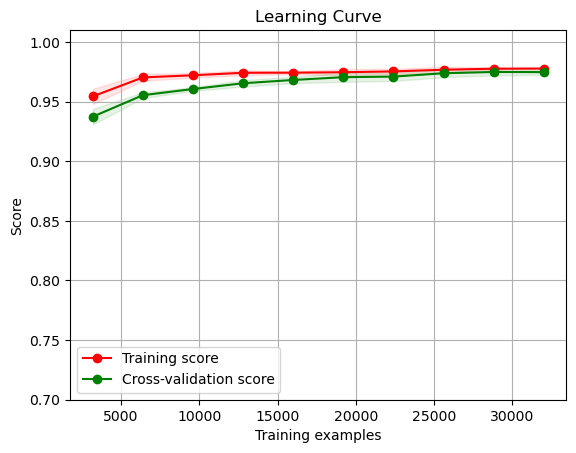

<Figure size 640x480 with 0 Axes>

In [8]:
# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate training scores mean
train_scores_mean = np.mean(train_scores, axis=1)
# Calculate training scores standard deviation
train_scores_std = np.std(train_scores, axis=1)
# Calculate test scores mean
test_scores_mean = np.mean(test_scores, axis=1)
# Calculate test score standard deviation
test_scores_std = np.std(test_scores, axis=1)

# Create a new figure
plt.figure()
# Set the title of the plot
plt.title("Learning Curve")
# Label the x-axis
plt.xlabel("Training examples")
# Label the y-axis
plt.ylabel("Score")
# Set the y-axis limits
plt.ylim((0.7, 1.01))
# Enable grid lines for the plot
plt.grid()

# Plot the shaded area for standard deviation of training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

# Plot the shaded area for standard deviation of test cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Plot the mean training scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot the mean test cross-validation scores
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

# Add a legend to the plot
plt.legend(loc="best")
# Display the plot
plt.show()

### Confusion Matrix

In [9]:
# Import Confusion Matrix
from sklearn.metrics import confusion_matrix

# Show Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

cm

array([[2269,  118],
       [ 124, 7489]], dtype=int64)

### Save Model and Pipeline

In [10]:
from joblib import dump, load

# Save the trained model
dump(grid_search.best_estimator_, 'best_model_xgboost.joblib')
# Save the pipeline
dump(pipeline, 'pipeline_xgboost.joblib')

['pipeline_xgboost.joblib']

### Features Importance

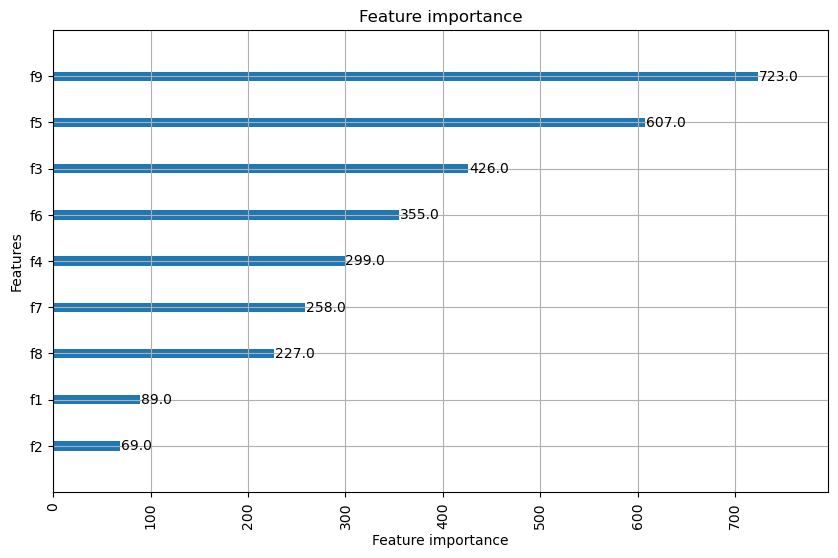

<Figure size 640x480 with 0 Axes>

In [11]:
from xgboost import plot_importance

# Get the best model from the grid search
best_model = grid_search.best_estimator_.named_steps['classifier']

# Get the feature names
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=11, ax=plt.gca(), 
                importance_type='weight', show_values=True, 
                xlabel='Feature importance', ylabel='Features')
plt.xticks(rotation=90)
plt.show()

f9- Efficient use of medical imaging national comparison * f5- Readmission national comparison * f3- Mortaliity national comparison * f6 - Patient experience national comparison * f4 - Safety of care national comparison * f7 - Effectiveness of care national comparison * f8 - Timeliness of care national comparison * f1 - Hospital Ownership Group * f2 - Hospital Type

## Decision Tree

In [12]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Randomly select 50,000 rows for modelling
size = 50000
train_df = df.sample(n=size, random_state=42)

# Define columns not needed for modelling
irrelevant_columns = ['HCAHPS Measure ID', 'Patient Survey Star Rating', 'HCAHPS Answer Percent',
                      'HCAHPS Linear Mean Value', 'Number of Completed Surveys',
                      'Survey Response Rate Percent', 'Start Date', 'End Date', 'Hospital overall rating']

# Define columns for modelling and target variable
features = ['Hospital Type', 'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
            'Safety of care national comparison', 'Readmission national comparison', 'Patient experience national comparison', 
            'Effectiveness of care national comparison', 'Timeliness of care national comparison', 
            'Efficient use of medical imaging national comparison', 'Sentiment Categories']

# Define target
target = 'Eligible For Funding'


# Assign label encoders
label_encoders = {feature: LabelEncoder() for feature in features}

# Encode categorical features
for feature in features:
    train_df[feature] = label_encoders[feature].fit_transform(train_df[feature])
train_df.drop(irrelevant_columns, axis=1, inplace=True)

X = train_df[features]
y = train_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('smoteenn', SMOTEENN(sampling_strategy='all', random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
     'classifier__criterion': ['gini', 'entropy'],
     'classifier__max_depth': [None, 10, 20, 30],
     'classifier__min_samples_split': [2, 5, 10],
     'classifier__min_samples_leaf': [1, 2, 4]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=3)

# Measure time
start_time = time.time() # Start time

# Fit the model
grid_search.fit(X_train, y_train)

end_time = time.time() # End time

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.968 total time=  20.6s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.973 total time=  30.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.966 total time=  23.4s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.973 total time=  19.2s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.971 total time=  22.1s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=1, classif

[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.926 total time=  30.5s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.933 total time=  25.7s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.931 total time=  25.0s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.929 total time=  27.6s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.937 total time=  30.0s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.926 total time=  44.1s
[CV 1/5] END cla

[CV 5/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=5;, score=0.968 total time=  24.6s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.965 total time=  26.0s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.971 total time=  23.3s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.964 total time=  23.6s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.974 total time=  25.1s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.966 total time=  29.6s
[CV 1/5] EN

[CV 5/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.966 total time=  21.1s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.967 total time=  21.9s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.971 total time=  23.6s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.962 total time=  18.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.973 total time=  17.7s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=30, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.967 total time=  18.4s
[CV 1/5] END cl

[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=2;, score=0.966 total time=  26.7s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.968 total time=  22.5s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.972 total time=  49.0s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.967 total time=  29.5s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.974 total time=  32.6s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.967 total

[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.936 total time=  21.8s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=5;, score=0.930 total time=  22.7s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.934 total time=  27.9s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.926 total time=  22.4s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.935 total time=  17.0s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.936 total time=  

[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.966 total time=  32.1s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.974 total time=  27.3s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=10;, score=0.964 total time=  24.7s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.967 total time=  23.4s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.971 total time=  25.4s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=20, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.965 total time=  2

[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.971 total time=  18.1s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.965 total time=  18.2s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.973 total time=  21.0s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=2;, score=0.964 total time=  17.2s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=5;, score=0.967 total time=  18.9s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=30, classifier__min_samples_leaf=4, classifier__min_samples_split=5;, score=0.971 total time=  19.2

### Print Model Result

In [13]:
# Print results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy on Test Set: {accuracy:.2f}')
print('Classification Report on Test Set:\n', classification_report_str)
print(f"Time taken for model compilation: {end_time - start_time:.2f} seconds")

# Checking cross-validation scores to ensure no overfitting
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

# Ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy on Test Set: 0.98
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      2387
           1       0.98      0.99      0.98      7613

    accuracy                           0.98     10000
   macro avg       0.97      0.96      0.97     10000
weighted avg       0.98      0.98      0.98     10000

Time taken for model compilation: 6205.75 seconds
Cross-validation scores: [0.969    0.973875 0.967125 0.974375 0.969875]
Average cross-validation score: 0.9708500000000001


### Learning Curve

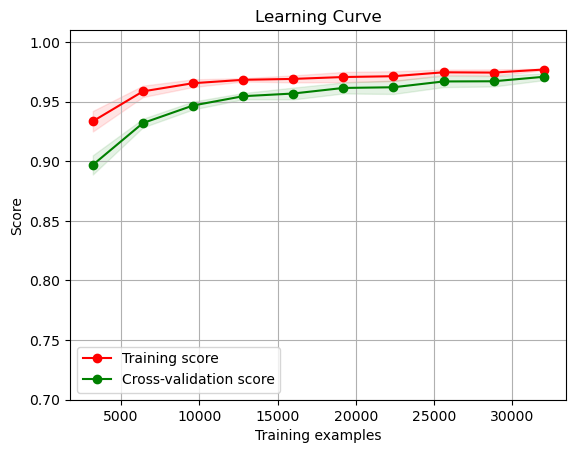

<Figure size 640x480 with 0 Axes>

In [14]:
# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate training scores mean
train_scores_mean = np.mean(train_scores, axis=1)
# Calculate training scores standard deviation
train_scores_std = np.std(train_scores, axis=1)
# Calculate test scores mean
test_scores_mean = np.mean(test_scores, axis=1)
# Calculate test score standard deviation
test_scores_std = np.std(test_scores, axis=1)

# Create a new figure
plt.figure()
# Set the title of the plot
plt.title("Learning Curve")
# Label the x-axis
plt.xlabel("Training examples")
# Label the y-axis
plt.ylabel("Score")
# Set the y-axis limits
plt.ylim((0.7, 1.01))
# Enable grid lines for the plot
plt.grid()

# Plot the shaded area for standard deviation of training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

# Plot the shaded area for standard deviation of test cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Plot the mean training scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot the mean test cross-validation scores
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

# Add a legend to the plot
plt.legend(loc="best")
# Display the plot
plt.show()

### Confusion Matrix

In [15]:
# Import Confusion Matrix
from sklearn.metrics import confusion_matrix

# Show Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

cm

array([[2254,  133],
       [ 114, 7499]], dtype=int64)

### Save Model and Pipeline

In [16]:
# Save the model
dump(grid_search.best_estimator_, 'best_model_decisiontree.joblib')
# Save the pipeline
dump(pipeline, 'pipeline_decisiontree.joblib')

['pipeline_decisiontree.joblib']

## K-Nearest Neighbor

In [17]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Randomly select 50,000 rows for modelling
size = 50000
train_df = df.sample(n=size, random_state=42)

# Define columns not needed for modelling
irrelevant_columns = ['HCAHPS Measure ID', 'Patient Survey Star Rating', 'HCAHPS Answer Percent',
                      'HCAHPS Linear Mean Value', 'Number of Completed Surveys',
                      'Survey Response Rate Percent', 'Start Date', 'End Date', 'Hospital overall rating']

# Define columns for modelling and target variable
features = ['Hospital Type', 'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
            'Safety of care national comparison', 'Readmission national comparison', 'Patient experience national comparison', 
            'Effectiveness of care national comparison', 'Timeliness of care national comparison', 
            'Efficient use of medical imaging national comparison', 'Sentiment Categories']

# Assign label encoders
label_encoders = {feature: LabelEncoder() for feature in features}

# Encode categorical features
for feature in features:
    train_df[feature] = label_encoders[feature].fit_transform(train_df[feature])
train_df.drop(irrelevant_columns, axis=1, inplace=True)

X = train_df[features]
y = train_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('smoteenn', SMOTEENN(sampling_strategy='all', random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=3)

# Measure time
start_time = time.time() # Start time

# Fit the model
grid_search.fit(X_train, y_train)

end_time = time.time() # End time

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.930 total time=  23.6s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.945 total time=  21.7s
[CV 3/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.929 total time=  19.9s
[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.934 total time=  27.0s
[CV 5/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform;, score=0.936 total time=  23.4s
[CV 1/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance;, score=0.931 total time=  23.0s
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance;, score=0.946 total time=  22.9s
[CV 3/5] END classif

### Print Model Result

In [18]:
# Print results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy on Test Set: {accuracy:.2f}')
print('Classification Report on Test Set:\n', classification_report_str)
print(f"Time taken for model compilation: {end_time - start_time:.2f} seconds")

# Checking cross-validation scores to ensure no overfitting
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Accuracy on Test Set: 0.94
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.85      0.93      0.88      2387
           1       0.98      0.95      0.96      7613

    accuracy                           0.94     10000
   macro avg       0.91      0.94      0.92     10000
weighted avg       0.95      0.94      0.94     10000

Time taken for model compilation: 1364.25 seconds
Cross-validation scores: [0.93425  0.948    0.93425  0.938375 0.940625]
Average cross-validation score: 0.9391


### Learning Curve

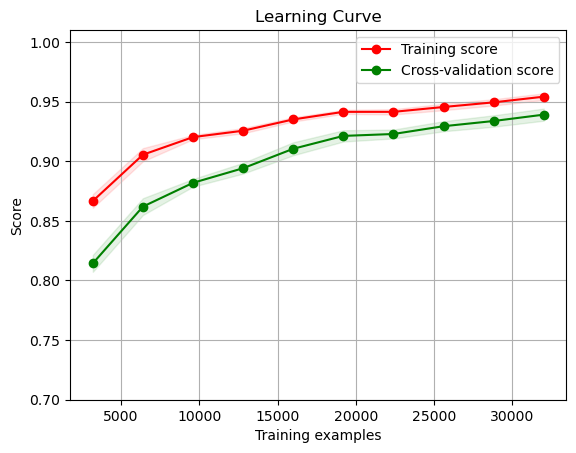

<Figure size 640x480 with 0 Axes>

In [19]:
# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting learning curve
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate training scores mean
train_scores_mean = np.mean(train_scores, axis=1)
# Calculate training scores standard deviation
train_scores_std = np.std(train_scores, axis=1)
# Calculate test scores mean
test_scores_mean = np.mean(test_scores, axis=1)
# Calculate test score standard deviation
test_scores_std = np.std(test_scores, axis=1)

# Create a new figure
plt.figure()
# Set the title of the plot
plt.title("Learning Curve")
# Label the x-axis
plt.xlabel("Training examples")
# Label the y-axis
plt.ylabel("Score")
# Set the y-axis limits
plt.ylim((0.7, 1.01))
# Enable grid lines for the plot
plt.grid()

# Plot the shaded area for standard deviation of training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")

# Plot the shaded area for standard deviation of test cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Plot the mean training scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot the mean test cross-validation scores
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

# Add a legend to the plot
plt.legend(loc="best")
# Display the plot
plt.show()

### Confusion Matrix

In [21]:
# Import Confusion Matrix
from sklearn.metrics import confusion_matrix

# Show Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

cm

array([[2213,  174],
       [ 402, 7211]], dtype=int64)

### Save Model and Pipeline

In [22]:
from joblib import dump, load

# Save the model
dump(grid_search.best_estimator_, 'best_model_knn.joblib')
# Save the pipelinr
dump(pipeline, 'pipeline_knn.joblib')

['pipeline_knn.joblib']

## Predicting New Dataset with the Best Model: XGBOOST

In [23]:
# Load the model from disk
best_model = load('best_model_xgboost.joblib')

new_df_encoded = new_df.copy()

# Features to encode
features = ['Hospital Type', 'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
            'Safety of care national comparison', 'Readmission national comparison', 'Patient experience national comparison', 
            'Effectiveness of care national comparison', 'Timeliness of care national comparison', 
            'Efficient use of medical imaging national comparison', 'Sentiment Categories']

# Encode categorical features in the new data
label_encoders = {}

for feature in features:
    label_encoder = LabelEncoder()
    label_encoder.fit(new_df[feature])
    new_df_encoded[feature] = label_encoder.transform(new_df[feature])
    label_encoders[feature] = label_encoder
    

# Add prediction to the DataFrame
predicted_eligibility = best_model.predict(new_df_encoded[features])

# Create a new DataFrame with predicted eligibility
new_df['Eligible For Funding'] = predicted_eligibility

# Filter the column to select only eligible facilities
new_eligibility_df = new_df[new_df['Eligible For Funding'] == 1]

# Create eligible facilities dataframe
eligible_facilities = new_eligibility_df[['Hospital Type', 'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
            'Safety of care national comparison', 'Readmission national comparison', 'Patient experience national comparison', 
            'Effectiveness of care national comparison', 'Timeliness of care national comparison', 
            'Efficient use of medical imaging national comparison', 'Sentiment Categories', 'Eligible For Funding']]

# Select additional columns
additional_columns = ['Facility ID', 'Facility Name', 'Address', 'City', 'Full State Name', 'ZIP Code',
                      'County Name', 'Phone Number', 'HCAHPS Answer Description']

# Join with the original unencoded new_df to get the additional columns
eligible_facilities = eligible_facilities.join(new_df[additional_columns], rsuffix='_orig')

# Order DataFrame
ordered_columns = ['Facility ID', 'Facility Name', 'Address', 'City', 'Full State Name', 'ZIP Code',
                   'County Name', 'Phone Number', 'HCAHPS Answer Description', 'Hospital Type', 
                   'Hospital Ownership Group', 'Emergency Services', 'Mortality national comparison', 
                   'Safety of care national comparison', 'Readmission national comparison', 
                   'Patient experience national comparison','Effectiveness of care national comparison', 
                   'Timeliness of care national comparison', 'Efficient use of medical imaging national comparison', 
                   'Sentiment Categories', 'Eligible For Funding']

# Set ordered column
eligible_facilities = eligible_facilities[ordered_columns]

# Display the resulting DataFrame
eligible_facilities

,Facility ID,Facility Name,Address,City,Full State Name,ZIP Code,County Name,Phone Number,HCAHPS Answer Description,Hospital Type,Hospital Ownership Group,Emergency Services,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Sentiment Categories,Eligible For Funding
0,10001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,Alabama,36301,Houston,(334) 793-8701,Nurses always communicated well,Acute Care,Government,Yes,Below,Same,Below,Below,Same,Same,Same,Neutral,1
1,10001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,Alabama,36301,Houston,(334) 793-8701,Nurses sometimes or never communicated well,Acute Care,Government,Yes,Below,Same,Below,Below,Same,Same,Same,Negative,1
2,10001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,Alabama,36301,Houston,(334) 793-8701,Nurses usually communicated well,Acute Care,Government,Yes,Below,Same,Below,Below,Same,Same,Same,Neutral,1
3,10001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,Alabama,36301,Houston,(334) 793-8701,Nurse communication - star rating,Acute Care,Government,Yes,Below,Same,Below,Below,Same,Same,Same,Very Positive,1
4,10001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,Alabama,36301,Houston,(334) 793-8701,Nurses always treated them with courtesy and ...,Acute Care,Government,Yes,Below,Same,Below,Below,Same,Same,Same,Very Positive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,490069,BON SECOURS MEMORIAL REGIONAL MEDICAL CENTER,8260 ATLEE ROAD,MECHANICSVILLE,Virginia,23116,Hanover,(804) 764-6000,"Yes, staff did give patients information about...",Acute Care,Voluntary non-profit,Yes,Same,Above,Above,Same,Same,Below,Same,Positive,1
165472,490069,BON SECOURS MEMORIAL REGIONAL MEDICAL CENTER,8260 ATLEE ROAD,MECHANICSVILLE,Virginia,23116,Hanover,(804) 764-6000,"No, staff did not give patients information ab...",Acute Care,Voluntary non-profit,Yes,Same,Above,Above,Same,Same,Below,Same,Positive,1
165474,490069,BON SECOURS MEMORIAL REGIONAL MEDICAL CENTER,8260 ATLEE ROAD,MECHANICSVILLE,Virginia,23116,Hanover,(804) 764-6000,Patients who Agree they understood their care ...,Acute Care,Voluntary non-profit,Yes,Same,Above,Above,Same,Same,Below,Same,Positive,1
165479,490069,BON SECOURS MEMORIAL REGIONAL MEDICAL CENTER,8260 ATLEE ROAD,MECHANICSVILLE,Virginia,23116,Hanover,(804) 764-6000,Patients who Disagree or Strongly Disagree tha...,Acute Care,Voluntary non-profit,Yes,Same,Above,Above,Same,Same,Below,Same,Very Positive,1


1    125964
0     39517
Name: Eligible For Funding, dtype: int64


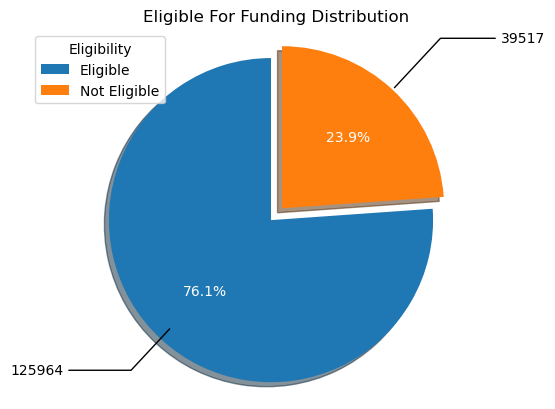

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

value_counts = new_df['Eligible For Funding'].value_counts()

print(value_counts)

labels = value_counts.index
sizes = value_counts.values
explode = (0.1, 0)

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True, textprops=dict(color="w"))

ax.axis('equal')

# Add count value text to the chart
for i, wedge in enumerate(wedges):
    # Position the text to be in the middle of each wedge
    angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = np.cos(np.radians(angle))
    y = np.sin(np.radians(angle))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(angle)
    ax.annotate(f'{sizes[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, textcoords="data",
                arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle))

# Add legend
ax.legend(wedges, ['Eligible', 'Not Eligible'],
          title="Eligibility",
          loc="upper left")

plt.title('Eligible For Funding Distribution')

# Save the plot as a PNG file
plt.savefig('eligible_for_funding_distribution.png')

plt.show()

In [26]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os

# Create the CSV file
csv_file_name = "eligible_facilities_df.csv"
df.to_csv(csv_file_name, index=False)

# Azure connection string
connect_str = "DefaultEndpointsProtocol=https;AccountName=thegroupproject;AccountKey=ZrsqB0h1P58bItB4WmuXcKAzGbXBFI/mGa6M6jYYvyuPgDQ5kqjPI8DJbvDhSsuwqVQqwoqzU8mA+AStHubvaQ==;EndpointSuffix=core.windows.net"

# Create the BlobServiceClient object
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Select the container to upload the file to
container_name = "healthcare-group-project"

# Create the BlobClient object
blob_client = blob_service_client.get_blob_client(container=container_name, blob=csv_file_name)

try:
    # Open the CSV file and upload its content to Azure Blob Storage
    with open(csv_file_name, "rb") as data:
        blob_client.upload_blob(data, overwrite=True)  # Added overwrite=True to handle the case if the blob already exists
    print(f"Successfully uploaded {csv_file_name} to Azure Blob Storage.")
except Exception as e:
    print(f"Error occurred: {str(e)}")

Successfully uploaded eligible_facilities_df.csv to Azure Blob Storage.
